## This is the experimentation of buildinding FNN for classification problem in Ex 1

Epoch [25/1000], Loss in training set: 0.7004, Loss in Test set: 0.7519
Class counts before using Weighted Random Sampler [170 285]
Class counts after using Weighted Random Sampler [209 246]

Epoch [50/1000], Loss in training set: 0.6684, Loss in Test set: 0.7270
Class counts before using Weighted Random Sampler [170 285]
Class counts after using Weighted Random Sampler [212 243]

Epoch [75/1000], Loss in training set: 0.6421, Loss in Test set: 0.6983
Class counts before using Weighted Random Sampler [170 285]
Class counts after using Weighted Random Sampler [209 246]

Epoch [100/1000], Loss in training set: 0.6009, Loss in Test set: 0.6642
Class counts before using Weighted Random Sampler [170 285]
Class counts after using Weighted Random Sampler [255 200]

Epoch [125/1000], Loss in training set: 0.5500, Loss in Test set: 0.6226
Class counts before using Weighted Random Sampler [170 285]
Class counts after using Weighted Random Sampler [224 231]

Epoch [150/1000], Loss in training set

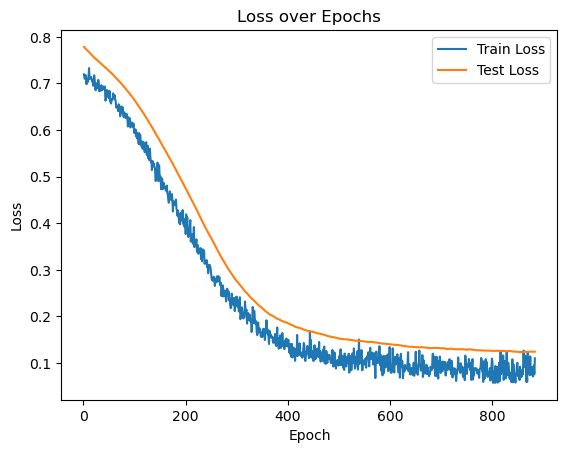

In [5]:
# IMPORTANT LIBRARIES

from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler

import pandas as pd

cancer=load_breast_cancer()

#Convert it to dataframe
df=pd.DataFrame(data=cancer.data, columns=cancer.feature_names)
target=pd.Series(cancer.target)


#Appling PCA for dimentionality Reduction with varriance 80 %
df=StandardScaler().fit_transform(df)
data_pca=PCA(0.8).fit_transform(df)
df_pca=pd.DataFrame(data_pca)


#Convert df to tensor
x=torch.tensor(df_pca.values).type(torch.float)  #df_pca.values is a numpy array you need numpy array to pass through 
y=torch.tensor(target.values).type(torch.float)

#Train Test split
#Stratified sampling applied on y
X_train, X_test, Y_train, Y_test=train_test_split(x,y, test_size=0.2, stratify=y, random_state=42)

#Split the dataset into diffrent Batches before passing the NN
train_dataset= TensorDataset(X_train, Y_train)

test_dataset=TensorDataset(X_test, Y_test)
test_loader=DataLoader(test_dataset, batch_size=16, shuffle=False)

#Build Sequential model
model=nn.Sequential(
    nn.Linear(in_features=5, out_features=32, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=16, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=8, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=8, out_features=1, bias=True),
    nn.Sigmoid()
)

#Can you pass throuh the data ?
#yes
#print(model(X_test))

#Create a Binary Cross Entropy Loss Function
Loss=nn.BCELoss()

#Set up the optimizer
optim=torch.optim.SGD(params=model.parameters(),lr=0.001)


# Regularization parameters
lambda1 = 0.0001  # L1 regularization strength
lambda2 = 0.0001  # L2 regularization strength

# Early Stopping class
class EarlyStopping:
    def __init__(self, patience=25, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Set the number of epochs
epochs = 1000
early_stopping = EarlyStopping(patience=25)

train_losses=[]
test_losses=[]

for epoch in range(epochs):
    
    
    #Weighted Random Sampling for balacing the dataset
    class_sample_counts =np.bincount(Y_train.type(torch.int64))
    #print('Class counts before using Weighted Random Sampler', class_sample_counts)
    
    # Calculate weights for each class
    class_counts = Counter(Y_train.numpy())
    class_weights = {cls: 1.0/count for cls, count in class_counts.items()}
    samples_weights = np.array([class_weights[cls] for cls in Y_train.numpy()])

    
    #samples_weights = weights[Y_train.type(torch.int64)]# Create the sampler
    sampler = WeightedRandomSampler(samples_weights, len(samples_weights), replacement=True)
    
    #Split the Training dataset into diffrent Batches
    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
    
    
    # Calculate the class distribution in the oversampled data
    sampled_indices = list(sampler)
    sampled_labels = Y_train[sampled_indices]
    class_counts_after_sampling =  np.bincount(sampled_labels)
    #print('Class counts after using Weighted Random Sampler', class_counts_after_sampling)
    
    #Model Train
    model.train()
    
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
    
    
        #Forward pass (model outputs raw logits)
        y_logits=model(inputs)
        y_logits=y_logits.squeeze()
    
    
        #Applying rounding off to make it 0 or 1
        #y_pred=torch.round(y_logits)
    
        #Calculate loss/accuracy 
        loss_train=Loss(y_logits, labels)  
        
        
        
        # L1 regularization term
        l1_reg = sum(torch.norm(param, 1) for param in model.parameters())
        
        # L2 regularization term
        l2_reg = sum(torch.norm(param, 2)**2 for param in model.parameters())
    
    
        total_loss = loss_train + lambda1 * l1_reg + lambda2 * l2_reg
    
        #Back Propagation
        
        #Initialze Optimizer with zero grad
        optim.zero_grad()
        total_loss.backward()
        optim.step()
        
        
        running_loss += total_loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
               
        
    #Evaluate the model on the test
    model.eval()
    
    running_loss=0.0
    # Disable gradient computation
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs).squeeze()
            loss_val=Loss(outputs,labels)

            
            # L1 regularization term
            l1_reg = sum(torch.norm(param, 1) for param in model.parameters())
        
            # L2 regularization term
            l2_reg = sum(torch.norm(param, 2)**2 for param in model.parameters())

            total_loss = loss_val + lambda1 * l1_reg + lambda2 * l2_reg
            
            running_loss += total_loss.item()
            
    avg_test_loss = running_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    
    # Early stopping check
    early_stopping(avg_test_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break
       
    if (epoch +1) % 25 == 0:    
        print(f'Epoch [{epoch+1}/{epochs}], Loss in training set: {avg_train_loss:.4f}, Loss in Test set: {avg_test_loss:.4f}')
        print('Class counts before using Weighted Random Sampler', class_sample_counts)
        print('Class counts after using Weighted Random Sampler', class_counts_after_sampling)
        print()
        
# Plotting the results
#epochs = range(1, (epochs+1))
epochs = list(range(1, len(train_losses) + 1))
#plt.figure(figsize=(12, 4))

plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()   

## This is same as above but without L1/L2 regularizer 
## Added Dropout layer  instead

Epoch [25/1000], Loss in training set: 0.6834, Loss in Test set: 0.6517
Class counts before using Weighted Random Sampler [170 285]
Class counts after using Weighted Random Sampler [218 237]

Epoch [50/1000], Loss in training set: 0.6520, Loss in Test set: 0.6332
Class counts before using Weighted Random Sampler [170 285]
Class counts after using Weighted Random Sampler [237 218]

Epoch [75/1000], Loss in training set: 0.6240, Loss in Test set: 0.6089
Class counts before using Weighted Random Sampler [170 285]
Class counts after using Weighted Random Sampler [220 235]

Epoch [100/1000], Loss in training set: 0.6140, Loss in Test set: 0.5768
Class counts before using Weighted Random Sampler [170 285]
Class counts after using Weighted Random Sampler [215 240]

Epoch [125/1000], Loss in training set: 0.5584, Loss in Test set: 0.5331
Class counts before using Weighted Random Sampler [170 285]
Class counts after using Weighted Random Sampler [236 219]

Epoch [150/1000], Loss in training set

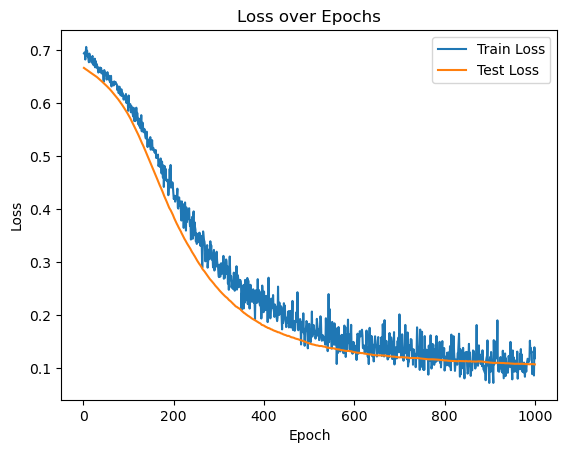

In [6]:
cancer=load_breast_cancer()

#Convert it to dataframe
df=pd.DataFrame(data=cancer.data, columns=cancer.feature_names)
target=pd.Series(cancer.target)


#Appling PCA for dimentionality Reduction with varriance 80 %
df=StandardScaler().fit_transform(df)
data_pca=PCA(0.8).fit_transform(df)
df_pca=pd.DataFrame(data_pca)


#Convert df to tensor
x=torch.tensor(df_pca.values).type(torch.float)  #df_pca.values is a numpy array you need numpy array to pass through 
y=torch.tensor(target.values).type(torch.float)

#Train Test split
#Stratified sampling applied on y
X_train, X_test, Y_train, Y_test=train_test_split(x,y, test_size=0.2, stratify=y, random_state=42)

#Split the dataset into diffrent Batches before passing the NN
train_dataset= TensorDataset(X_train, Y_train)

test_dataset=TensorDataset(X_test, Y_test)
test_loader=DataLoader(test_dataset, batch_size=16, shuffle=False)

#Build Sequential model
model=nn.Sequential(
    nn.Linear(in_features=5, out_features=32, bias=True),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(in_features=32, out_features=16, bias=True),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(in_features=16, out_features=8, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=8, out_features=1, bias=True),
    nn.Sigmoid()
)

#Can you pass throuh the data ?
#yes
#print(model(X_test))

#Create a Binary Cross Entropy Loss Function
Loss=nn.BCELoss()

#Set up the optimizer
optim=torch.optim.SGD(params=model.parameters(),lr=0.001)


# Set the number of epochs
epochs = 1000
early_stopping = EarlyStopping(patience=25)
train_losses=[]
test_losses=[]

for epoch in range(epochs):
    
    
    #Weighted Random Sampling for balacing the dataset
    class_sample_counts =np.bincount(Y_train.type(torch.int64))
    #print('Class counts before using Weighted Random Sampler', class_sample_counts)
    
    # Calculate weights for each class
    class_counts = Counter(Y_train.numpy())
    class_weights = {cls: 1.0/count for cls, count in class_counts.items()}
    samples_weights = np.array([class_weights[cls] for cls in Y_train.numpy()])

    sampler = WeightedRandomSampler(samples_weights, len(samples_weights), replacement=True)
    
    #Split the Training dataset into diffrent Batches
    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
    
    
    # Calculate the class distribution in the oversampled data
    sampled_indices=list(sampler)
    sampled_labels = Y_train[sampled_indices]
    class_counts_after_sampling =  np.bincount(sampled_labels)
    #print('Class counts after using Weighted Random Sampler', class_counts_after_sampling)
    
    #Model Train
    model.train()
    
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
    
    
        #Forward pass (model outputs raw logits)
        y_logits=model(inputs)
        y_logits=y_logits.squeeze()
    
    
        #Applying rounding off to make it 0 or 1
        #y_pred=torch.round(y_logits)
    
        #Calculate loss/accuracy 
        loss_train=Loss(y_logits, labels)  
        
        
    
        #Back Propagation
        
        #Initialze Optimizer with zero grad
        optim.zero_grad()
        loss_train.backward()
        optim.step()
        
        
        running_loss += loss_train.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
               
        
    #Evaluate the model on the test
    model.eval()
    
    running_loss=0.0
    # Disable gradient computation
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs).squeeze()
            loss_val=Loss(outputs,labels)
            
            total_loss = loss_val 
            
            running_loss += total_loss.item()
            
    avg_test_loss = running_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    # Early stopping check
    early_stopping(avg_test_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break
       
    if (epoch +1) % 25 == 0:    
        print(f'Epoch [{epoch+1}/{epochs}], Loss in training set: {avg_train_loss:.4f}, Loss in Test set: {avg_test_loss:.4f}')
        print('Class counts before using Weighted Random Sampler', class_sample_counts)
        print('Class counts after using Weighted Random Sampler', class_counts_after_sampling)
        print()
        
# Plotting the results
#epochs = range(1, (epochs+1))
epochs = list(range(1, len(train_losses) + 1))
#plt.figure(figsize=(12, 4))

plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()   

for inputs, labels in train_loader:
    class_sample_counts=np.bincount(labels.type(torch.int64))
    #samples_weights1=weights[labels.type(torch.int64)]
    #print(samples_weights1)
    #print(inputs.shape, labels.shape)
    print(class_sample_counts)

In [3]:
#conda install pytorch torchvision torchaudio -c pytorch

In [4]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'